# Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [6]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages    
    Outputs:
        processed_imarray: h x w x Nimages
    """
   
    im_shape = imarray.shape  
    processed_imarray = np.zeros(im_shape)
    
    #Subtract all the images in imarray by ambimage
    processed_imarray = imarray - ambimage[:,:,np.newaxis]

    #Set all the negative numbers in processed array to zero
    processed_imarray[processed_imarray < 0] = 0
    
    #Rescale
    processed_imarray = np.divide(processed_imarray,255.0)
  
    return processed_imarray

In [12]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
   Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3  
    """
    
    im = imarray.shape
    #to get a column vector all of the pixel in the intensity matrix format where the first 64 numbers are the (0,0) 
    #index of all the 64 images, then next 64 numbers are (1,0) index of the 64 images and so on
    #convert to one long arrary
    a = np.reshape(imarray,im[0]*im[1]*im[2],'F') 

    #convert into rows = nums of pixels and 64 columns 
    b = np.reshape(a,(im[0]*im[1],im[2]),'F')
    
    
    c = b.T
    
    #convert back to one long array but but now every 64 numbers are the same pixel index across images 
    d = np.reshape(c,im[0]*im[1]*im[2],'F')
    
    #setting up g array
    e= np.zeros((im[0]*im[1],3))
    
    #g = d.reshape((im[0]*im[1],1,64))

    for i in range(0,im[0]*im[1]):   
         e[i,:] = np.linalg.lstsq(light_dirs,d[64*i:64*i+64],rcond=None)[0]
            
    #transform back to a 3-d matrix h x w x 3 
    g_3d = np.reshape(e,(im[0],im[1],3),'F')

    normal_x = np.zeros((im[0],im[1]))
    normal_y = np.zeros((im[0],im[1]))
    normal_z = np.zeros((im[0],im[1]))

    surface_normals = np.zeros((im[0],im[1],3))

    fx = np.divide(g_3d[:,:,0],g_3d[:,:,2])     
    fy = np.divide(g_3d[:,:,1],g_3d[:,:,2])
    normal_z = 1/np.sqrt(fx**2+fy**2+1)

    surface_normals[:,:,0] = np.multiply(normal_z,fx)
    surface_normals[:,:,1] = np.multiply(normal_z,fy)
    surface_normals[:,:,2] = normal_z

    albedo_image = np.zeros((im[0],im[1]))
    albedo_image = np.sqrt(g_3d[:,:,0]**2+g_3d[:,:,1]**2+g_3d[:,:,2]**2)

    
    return albedo_image, surface_normals

In [ ]:
# print(imarray.shape)

firstpix = np.zeros(64)

firstpix = imarray[190,167,:]

g = np.linalg.lstsq(light_dirs, firstpix,rcond=None)[0]
#or you could using pseudoinverse np.linalg.pinv(light_dirs) then np.matmul(p_inv,firstpix)
print(firstpix)
print(g)


In [8]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
        
    """
    
    
    
    
    
    return height_map

# Main function

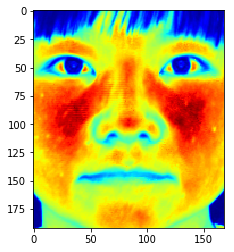

In [23]:
root_path = '../croppedyale/'
subject_name = 'yaleB05'
integration_method = 'average'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,light_dirs)

plt.imshow(albedo_image,cmap = 'jet')
plt.show()


# height_map = get_surface(surface_normals, 'average')

# if save_flag:
#     save_outputs(subject_name, albedo_image, surface_normals)




In [ ]:
plot_surface_normals(surface_normals)

In [ ]:
display_output(albedo_image, height_map)